<div style="text-align: center;">
    <h3>Applied Data Science Project</h3>
    <h2><b>Patient Preferences Studies Classification System</b><h2>
    <h1><b>Train & Test Binary Classification System</b></h1>
    <h5>Francesco Giuseppe Gillio</h5>
    <h5>César Augusto Seminario Yrigoyen</h5>
</div>

<div style="text-align: center;">
    <img src="https://upload.wikimedia.org/wikipedia/it/4/47/Logo_PoliTo_dal_2021_blu.png" width="250">
</div>

https://github.com/adsp-polito/2024-P8-PPS

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# *Drive* **Setup**

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Patient Preference Studies Binary Classifier
root = 'PPS-BC'

In [4]:
path = os.path.join('/content/drive/MyDrive', root)
if not os.path.exists(path):
    os.makedirs(path)

In [5]:
paths = {
    'input-data': f'{root}/input-data',
    'bert-embeddings': f'{root}/bert-embeddings',
    'notebook-results': f'{root}/notebook-results',
}

In [6]:
for key, value in paths.items():
    path = os.path.join('/content/drive/MyDrive', value)
    if not os.path.exists(path):
        os.makedirs(path)

**Notebook Directory Structure**
```
/PPS-BC
├── /input-data
│   └── ...
├── /bert-embeddings
│   └── ...
├── /notebook-results
│   ├── ...
│   └── /output-charts
│       ├── confusion-matrix.png
│       └── percentage-confusion-matrix.png
└── /models
    ├── biomed-svc-pipeline.joblib
    └── pubmed-knn-pipeline.joblib
```

# **Train & Test** *Binary Classification System*

**Requirements**

In [7]:
import os
import gc
import sys
import torch
import joblib

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import List, Tuple

In [8]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import (
    confusion_matrix,
    classification_report
)

In [9]:
np.random.seed(42)
torch.manual_seed(42)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
input = os.path.join(f"/content/drive/MyDrive", paths['input-data'], 'clean-articles-2023.csv')

In [12]:
# path to save the classification models
output = os.path.join(f"/content/drive/MyDrive/{root}", 'models')
if not os.path.exists(output):
    os.makedirs(output)

In [13]:
# path to save the confusion matrix charts
subpath = os.path.join(f"/content/drive/MyDrive/{paths['notebook-results']}", 'output-charts')
if not os.path.exists(subpath):
    os.makedirs(subpath)

**Train Function**

In [14]:
def train(
    input: str,
    device: str,
    threshold: int,
    weights: Tuple[int, int],
    path: str = 'models'
) -> Tuple[np.ndarray, np.ndarray]:
    """
    train and evaluate classification pipeline via BERT-base embeddings and machine learning models

    args:
        input (str): path to the input CSV dataset with 'title', 'abstract', and 'label' columns
        device (str): device for model computations ('cpu' or 'cuda')
        threshold (int): decision threshold for binary classification
        weights (Tuple[int, int]): weights for soft majority voting of classifier outputs
        path (str): directory to save post-train pipeline (defaults to 'models')

    returns:
        Tuple[np.ndarray, np.ndarray]: y_test (true labels) and preds (predictions)
    """

    def remove(model):
        """
        delete model and clear caches

        args:
            model: PyTorch model to remove from GPU memory
        """
        del model
        gc.collect()
        torch.cuda.empty_cache()

    def get(
        row: pd.Series,
        base: str,
        model: AutoModel,
        tokenizer: AutoTokenizer,
        device: str
    ) -> np.ndarray:
        """
        encodes the title and abstract of a dataset row into numerical embeddings by pre-trained BERT-base model

        args:
            row (pd.Series): row of the dataset with 'title' and 'abstract'
            base (str): identifier for the pre-trained BERT-base model
            model (AutoModel): pre-trained Hugging Face BERT-base model
            tokenizer (AutoTokenizer): tokenizer of the BERT-base model
            device (str): device for computations ('cpu' or 'cuda')

        returns:
            np.ndarray: numerical embeddings for the input row
        """

        title = [row['title']]
        abstract = [row['abstract']]

        def meanpooling(
            output: Tuple[torch.Tensor, ...],
            mask: torch.Tensor
        ) -> torch.Tensor:
            """
            compute mean pooling on embeddings by attention mask

            args:
                output (Tuple[torch.Tensor, ...]): model output
                mask (torch.Tensor): attention mask tensor

            returns:
                torch.Tensor: mean-pooling embeddings
            """
            embeddings = output[0]
            mask = mask.unsqueeze(-1).expand(embeddings.size()).float()
            return torch.sum(embeddings * mask, 1) / torch.clamp(mask.sum(1), min=1e-9)

        def tokenize(
            text: List[str],
            tokenizer: AutoTokenizer
        ) -> dict:
            """
            tokenize input text for the pre-trained BERT-base model

            args:
                text (List[str]): input text strings
                tokenizer (AutoTokenizer): tokenizer of the BERT-base model

            returns:
                dict: input tokens ready for the model
            """
            inputs = tokenizer(
                text,
                padding=True,
                truncation=True,
                return_tensors='pt',
                max_length=512
            )
            inputs = {
                key: value.to(device)
                for key, value in inputs.items()
            }
            return inputs

        def encode(
            text: List[str],
            model: AutoModel,
            tokenizer: AutoTokenizer,
            pooling: bool
        ) -> torch.Tensor:
            """
            compute embeddings for the input text by pre-trained BERT-base model

            args:
                text (List[str]): input text strings
                model (AutoModel): pre-trained BERT-base model
                tokenizer (AutoTokenizer): tokenizer of the BERT-base model
                pooling (bool): whether to compute mean pooling on embeddings

            returns:
                torch.Tensor: embeddings for the input text
            """
            inputs = tokenize(text, tokenizer)
            with torch.no_grad():
                output = model(**inputs)
            embeddings = output.pooler_output if not pooling else meanpooling(
                output,
                inputs['attention_mask']
           )
            return embeddings

        if base == 'NeuML/pubmedbert-base-embeddings':
            # vector concatenation of title and abstract embeddings
            # with classification token output (pooling = False)
            title = encode(title, model, tokenizer, pooling=False)
            abstract = encode(abstract, model, tokenizer, pooling=False)
            embeddings = torch.cat((title, abstract), dim=-1)
        elif base == 'microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract':
            # vector weighted average of title and abstract embeddings (20% title, 80% abstract)
            # with hidden states output (pooling = True)
            title = encode(title, model, tokenizer, pooling=True)
            abstract = encode(abstract, model, tokenizer, pooling=True)
            embeddings = 0.2 * title + 0.8 * abstract
        else:
            raise ValueError(f"unknown base model: {base}")
        return embeddings.cpu().numpy()


    if not os.path.exists(path):
        os.makedirs(path)

    print(f"reading dataset from {input}...")
    dataset = pd.read_csv(input)
    print(f"dataset size: {len(dataset)}")
    labels = dataset['label'].tolist()
    print(f"\nsplitting dataset into train and test sets...")
    titles_train, titles_test, abstracts_train, abstracts_test, y_train, y_test = train_test_split(
        dataset['title'], dataset['abstract'], labels,
        test_size=float(
            260 / 1215
        ),
        random_state=42,
        stratify=labels
    )
    print(f"train set size: {len(y_train)}, test set size: {len(y_test)}")
    results = {}
    for base, desc, classifier in [
        ('NeuML/pubmedbert-base-embeddings',
         'pubmed-knn-pipeline',
         KNeighborsClassifier(
             n_neighbors=5,
             weights="distance",
             metric="euclidean"
        )),
        ('microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract',
         'biomed-svc-pipeline',
         SVC(
             kernel="rbf",
             probability=True,
             class_weight="balanced",
             random_state=42,
             max_iter=1000,
             gamma='auto',
             C=1e1
        ))
    ]:
        print(f"\nprocessing {desc}...")
        print(f"loading {base}...")
        tokenizer = AutoTokenizer.from_pretrained(base)
        model = AutoModel.from_pretrained(base)
        model = model.to(device)
        x_train = list()
        for idx, row in pd.concat([
            titles_train, abstracts_train
            ], axis=1).reset_index(drop=True).iterrows():
            percentage = (idx + 1) / len(titles_train) * 100
            sys.stdout.write(f"\rencoding train data... {percentage:.2f}%")
            sys.stdout.flush()
            x_train.append(get(row, base, model, tokenizer, device))
        print()
        x_test = list()
        for idx, row in pd.concat([
            titles_test, abstracts_test
            ], axis=1).reset_index(drop=True).iterrows():
            percentage = (idx + 1) / len(titles_test) * 100
            sys.stdout.write(f"\rencoding test data... {percentage:.2f}%")
            sys.stdout.flush()
            x_test.append(get(row, base, model, tokenizer, device))
        print(f"\nstacking data for {desc}...")
        x_train = np.vstack(x_train)
        x_test = np.vstack(x_test)
        print(f"train data shape: {x_train.shape}, test data shape: {x_test.shape}")
        remove(model)
        print(f"training classifier for {desc}...")
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', classifier)
        ])
        pipeline.fit(x_train, y_train)
        output = f'{path}/{desc.replace(" ", "-")}.joblib'
        joblib.dump(pipeline, output)
        print(f"saving {desc} into {output}")
        print(f"computing predictions for {desc}...")
        preds = pipeline.predict_proba(x_test)
        results[base] = preds
    print(f"\nprocessing soft majority vote...")
    alpha, beta = results['NeuML/pubmedbert-base-embeddings'], results['microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract']
    a, b = weights
    probs = (alpha * a) + (beta * b)
    preds = (probs[:, 1] >= threshold).astype(int)
    print(f"\noutput:")
    print(classification_report(y_test, preds))
    return y_test, preds

**Plot Function**

In [15]:
def plot(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    path: str
):
    """
    plot classic and percentage-base confusion matrices

    args:
        y_true (np.ndarray): ground truth labels for the test set
        y_pred (np.ndarray): predictions for the test set
        path (str): path to store plots
    """
    # classic confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    labels = [
        [f"TN\n{cm[0, 0]}", f"FP\n{cm[0, 1]}"],
        [f"FN\n{cm[1, 0]}", f"TP\n{cm[1, 1]}"]
    ]
    plt.figure(figsize=(12.5, 10))
    sns.heatmap(
        cm,
        annot=labels,
        fmt='',
        cmap='rocket',
        xticklabels=['Non-PPS', 'PPS'],
        yticklabels=['Non-PPS', 'PPS'],
        cbar=True,
        annot_kws={'size': 12.5}
    )
    plt.title(
        'PubMed-BERT & K-NN x 0.4375 + BioMed-BERT & SVM x 0.5625, with threshold = 0.3875',
        fontsize=15
    )
    plt.xlabel(
        'Predicted',
        fontsize=12.5
    )
    plt.ylabel(
        'Actual',
        fontsize=12.5
    )
    plt.tick_params(
        axis='both',
        which='major',
        labelsize=12.5
    )
    plt.tight_layout()
    plt.savefig(
        f"{path}/confusion-matrix.png",
        dpi=300,
        bbox_inches='tight')
    plt.show()
    # percentage-base confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    labels = [
        [f"TN\n{cm[0, 0]:.2f}%", f"FP\n{cm[0, 1]:.2f}%"],
        [f"FN\n{cm[1, 0]:.2f}%", f"TP\n{cm[1, 1]:.2f}%"]
    ]
    plt.figure(figsize=(12.5, 10))
    sns.heatmap(
        cm,
        annot=labels,
        fmt='',
        cmap='rocket',
        xticklabels=['Non-PPS', 'PPS'],
        yticklabels=['Non-PPS', 'PPS'],
        cbar_kws={'format': '%.0f%%'},
        annot_kws={'size': 12.5}
    )
    plt.title(
        'PubMed-BERT & K-NN x 0.4375 + BioMed-BERT & SVM x 0.5625, with threshold = 0.3875',
        fontsize=15
    )
    plt.xlabel(
        'Predicted',
        fontsize=12.5
    )
    plt.ylabel(
        'Actual',
        fontsize=12.5
    )
    plt.tick_params(
        axis='both',
        which='major',
        labelsize=12.5
    )
    plt.tight_layout()
    plt.savefig(
        f"{path}/percentage-confusion-matrix.png",
        dpi=300,
        bbox_inches='tight')
    plt.show()

**Train Binary Classification System**

In [16]:
y_test, preds = train(
    input = input,
    device = device,
    threshold = 0.3875,
    weights = (0.4375, 0.5625),
    path = output
)

reading dataset from /content/drive/MyDrive/PPS-BC/input-data/clean-articles-2023.csv...
dataset size: 1215

splitting dataset into train and test sets...
train set size: 955, test set size: 260

processing pubmed-knn-pipeline...
loading NeuML/pubmedbert-base-embeddings...


tokenizer_config.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/706k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/667 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

encoding train data... 100.00%
encoding test data... 100.00%
stacking data for pubmed-knn-pipeline...
train data shape: (955, 1536), test data shape: (260, 1536)
training classifier for pubmed-knn-pipeline...
saving pubmed-knn-pipeline into /content/drive/MyDrive/PPS-BC/models/pubmed-knn-pipeline.joblib
computing predictions for pubmed-knn-pipeline...

processing biomed-svc-pipeline...
loading microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract...


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

encoding train data... 100.00%
encoding test data... 100.00%
stacking data for biomed-svc-pipeline...
train data shape: (955, 768), test data shape: (260, 768)
training classifier for biomed-svc-pipeline...
saving biomed-svc-pipeline into /content/drive/MyDrive/PPS-BC/models/biomed-svc-pipeline.joblib
computing predictions for biomed-svc-pipeline...

processing soft majority vote...

output:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       211
           1       0.87      0.96      0.91        49

    accuracy                           0.97       260
   macro avg       0.93      0.96      0.95       260
weighted avg       0.97      0.97      0.97       260



**Plot Confusion Matrix**

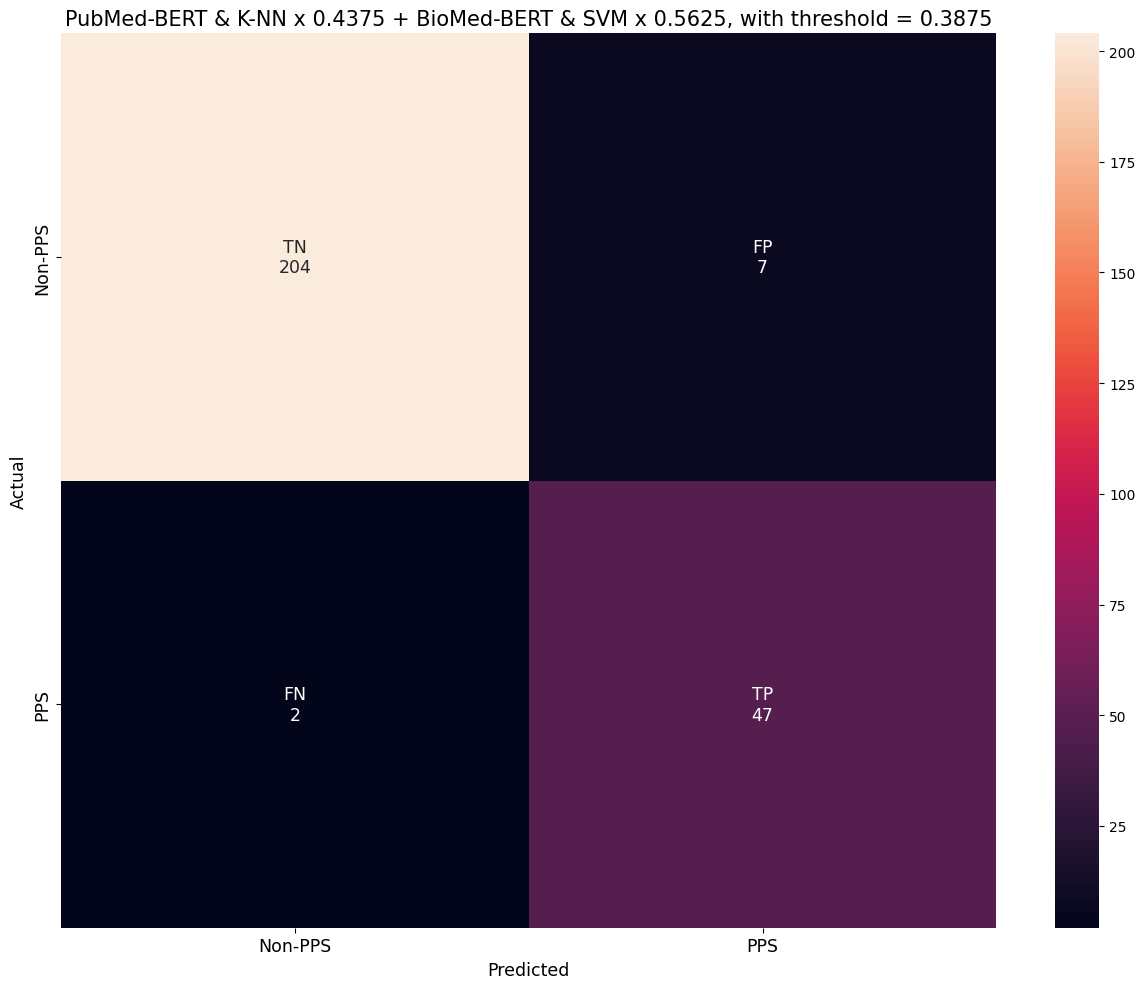

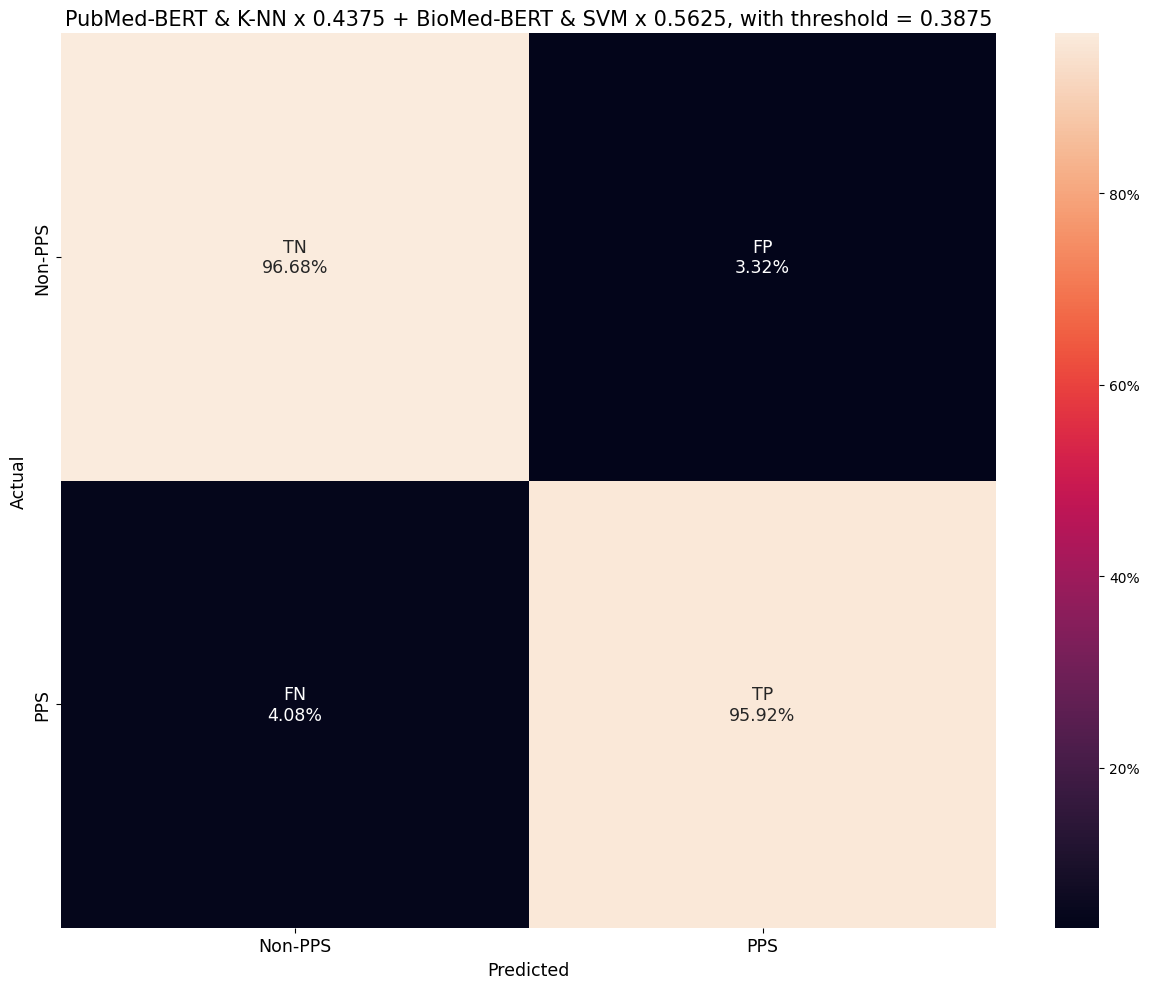

In [17]:
plot(
    y_true = y_test,
    y_pred = preds,
    path = subpath
)